In [108]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Reshape, Dense, Dropout, BatchNormalization, Conv2D, Conv2DTranspose, GlobalMaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam, Adadelta, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.keras import backend as K
plt.rc('figure', figsize=(12, 8), dpi=100)

In [109]:
(y_tr, _), (y_te, _) = cifar100.load_data()
y_tr = y_tr.astype('float32') / 255
y_te = y_te.astype('float32') / 255
x_tr = np.expand_dims([cv.cvtColor(x, cv.COLOR_RGB2GRAY) for x in y_tr], axis=3)
x_te = np.expand_dims([cv.cvtColor(x, cv.COLOR_RGB2GRAY) for x in y_te], axis=3)
print('x train shape', x_tr.shape)
print('y train shape', y_tr.shape)
print('x test  shape', x_te.shape)
print('y test  shape', y_te.shape)

x train shape (50000, 32, 32, 1)
y train shape (50000, 32, 32, 3)
x test  shape (10000, 32, 32, 1)
y test  shape (10000, 32, 32, 3)


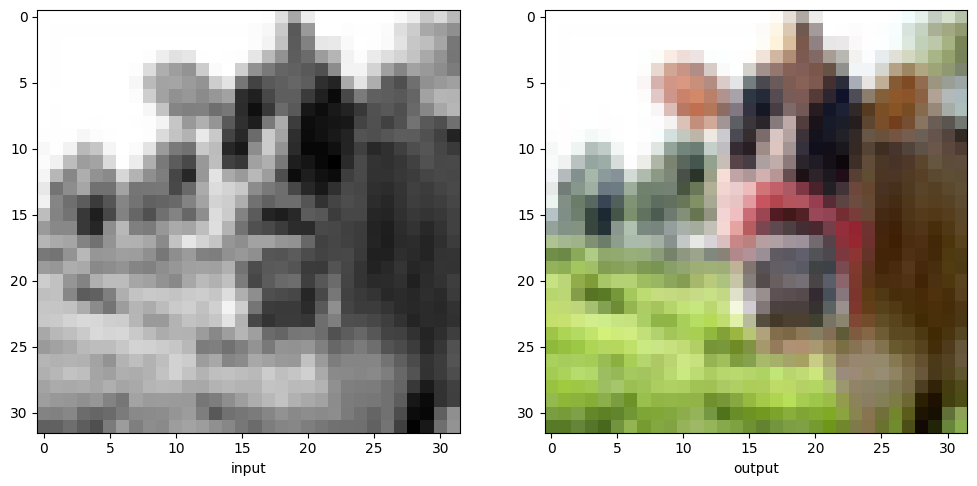

In [110]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.imshow(x_tr[0].reshape(32, 32), cmap='gray')
ax2.imshow(y_tr[0])
ax1.set_xlabel('input')
ax2.set_xlabel('output')
plt.show()

In [111]:
# NN tools
reduce_lr = ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-6, verbose=1)
optimizer = Adam(learning_rate=0.01)
compile = lambda it: it.compile(optimizer=optimizer, loss='mse')
fit = lambda it: it.fit(x_tr, y_tr, epochs=20, batch_size=128, validation_data=(x_te, y_te), callbacks=[reduce_lr])

def fit_models(models):
  for model in models:
    print(f'--- {model.name} -------------')
    compile(model)
    model.history = fit(model)
    
def plot_training(models, params):
  fig, axs = plt.subplots(ncols=2, figsize=(10, 3))
  labels = [x.name for x in models]
  for ax, param in zip(axs.reshape(-1), params):
    for model in models:
      ax.plot(model.history.history[param])
    ax.set_ylabel(param)
    ax.set_xlabel('epoch')
    ax.legend(labels, loc='upper right')
  plt.show()

In [112]:
class Encoder(Model):
  def __init__(self, filters, kernel, dropout, batchnorm):
    super().__init__(name='Encoder')
    self.mylayers = []
    for n in filters:
      self.mylayers.append(Conv2D(filters=n, kernel_size=kernel, strides=2, activation='relu', padding='same'))
      if batchnorm: self.mylayers.append(BatchNormalization())
      if dropout: self.mylayers.append(Dropout(dropout))

  def call(self, x):
    for layer in self.mylayers:
      x = layer(x)
    return x

class Decoder(Model):
  def __init__(self, filters, kernel, channels=3):
    super().__init__(name='Decoder')
    self.mylayers = []
    for n in filters:
      self.mylayers.append(Conv2DTranspose(filters=n, kernel_size=kernel, strides=2, activation='relu', padding='same'))
    self.mylayers.append(Conv2D(filters=channels, kernel_size=kernel, activation='sigmoid', padding='same'))

  def call(self, x):
    for layer in self.mylayers:
      x = layer(x)
    return x

class Autoencoder(Model):
  def __init__(self, name, filters, kernel=3, dropout=None, batchnorm=False):
    super().__init__(name=name)
    self.encoder = Encoder(filters, kernel, dropout, batchnorm)
    self.decoder = Decoder(filters[::-1], kernel)

  def call(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [123]:
filters_s = [64, 128, 256]
kernel_s = 3
models = [
  #Autoencoder(filters=filters_s, kernel=kernel_s, batchnorm=False, dropout=False, name='small'),
  Autoencoder(filters=filters_s, kernel=kernel_s, batchnorm=True , dropout=False, name='small_batchnorm'),
  #Autoencoder(filters=filters_s, kernel=kernel_s, batchnorm=False, dropout=0.2  , name='small_dropout'),
  #Autoencoder(filters=filters_s, kernel=kernel_s, batchnorm=True , dropout=0.2  , name='small_batchnorm_dropout'),
]
fit_models(models)

--- small_batchnorm -------------
Epoch 1/20
391/391 [==============================] - 13s 31ms/step - loss: 0.0188 - val_loss: 0.0365
Epoch 2/20
391/391 [==============================] - 12s 31ms/step - loss: 0.0107 - val_loss: 0.0103
Epoch 3/20
391/391 [==============================] - 12s 32ms/step - loss: 0.0101 - val_loss: 0.0105
Epoch 4/20
391/391 [==============================] - 12s 32ms/step - loss: 0.0096 - val_loss: 0.0098
Epoch 5/20
391/391 [==============================] - 12s 31ms/step - loss: 0.0094 - val_loss: 0.0100
Epoch 6/20
391/391 [==============================] - 12s 31ms/step - loss: 0.0092 - val_loss: 0.0098

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.
Epoch 7/20
391/391 [==============================] - 12s 31ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 8/20
391/391 [==============================] - 12s 31ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 9/20
391/391 [==============================] - 12s 31ms/step 

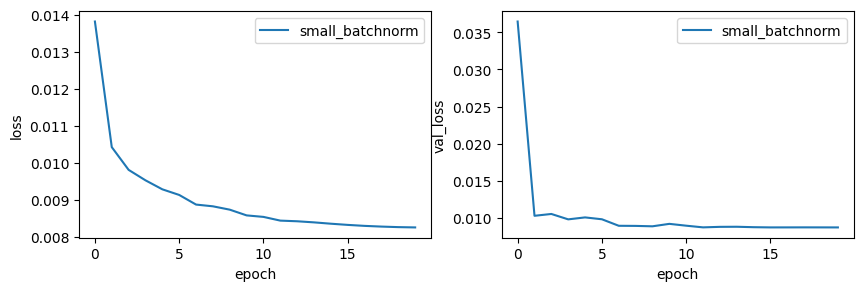

In [124]:
plot_training(models, params=['loss', 'val_loss'])

In [125]:
Y_te = models[0].predict(x_te[:100,:,:,:])
print(Y_te.shape)

(100, 32, 32, 3)


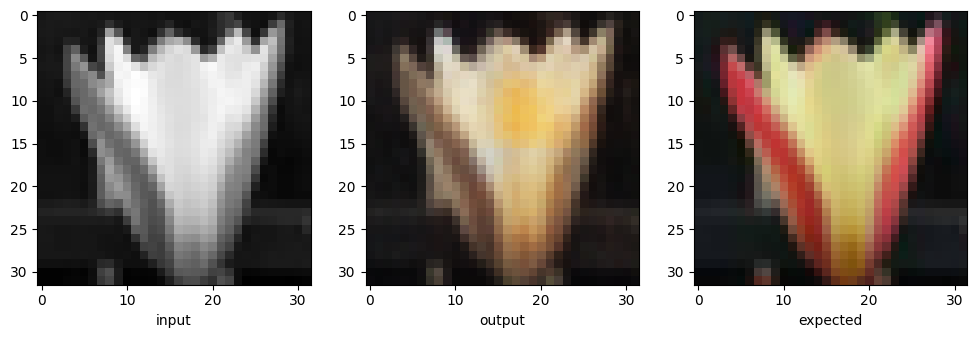

In [126]:
def plot_result(x, y, Y):
  fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
  ax1.imshow(x.reshape(x.shape[0], x.shape[1]), cmap='gray')
  ax2.imshow(Y)
  ax3.imshow(y)
  ax1.set_xlabel('input')
  ax2.set_xlabel('output')
  ax3.set_xlabel('expected')
  
def plot_test_result(index):
  plot_result(x_te[index], y_te[index], Y_te[index])

plot_test_result(16)

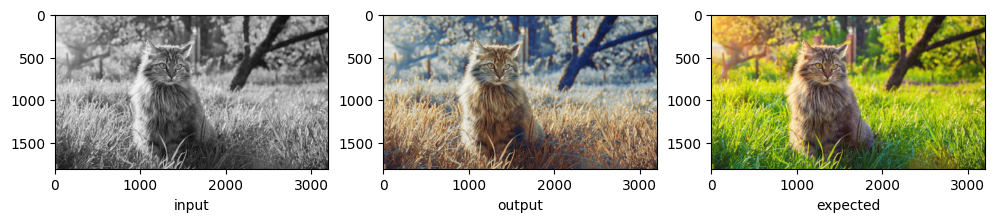

In [127]:
def plot_disk_image(model, path):
  y = cv.cvtColor(cv.imread(path), cv.COLOR_BGR2RGB).astype('float32') / 255
  x = cv.cvtColor(y, cv.COLOR_RGB2GRAY)
  Y = model.predict(x.reshape(1, x.shape[0], x.shape[1], 1))[0]
  plot_result(x, y, Y)

plot_disk_image(models[0], 'cat.jpg')